In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from collections import Counter

In [2]:
train_dir = './Training'
test_dir = './Testing'

In [18]:
# Use ImageDataGenerator to import images from the class folders
# Apply data augmentation to the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [19]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [20]:
# Class counts seem fairly balanced
class_count = Counter(train_data.classes)
class_count

Counter({2: 1276, 3: 1166, 1: 1072, 0: 1057})

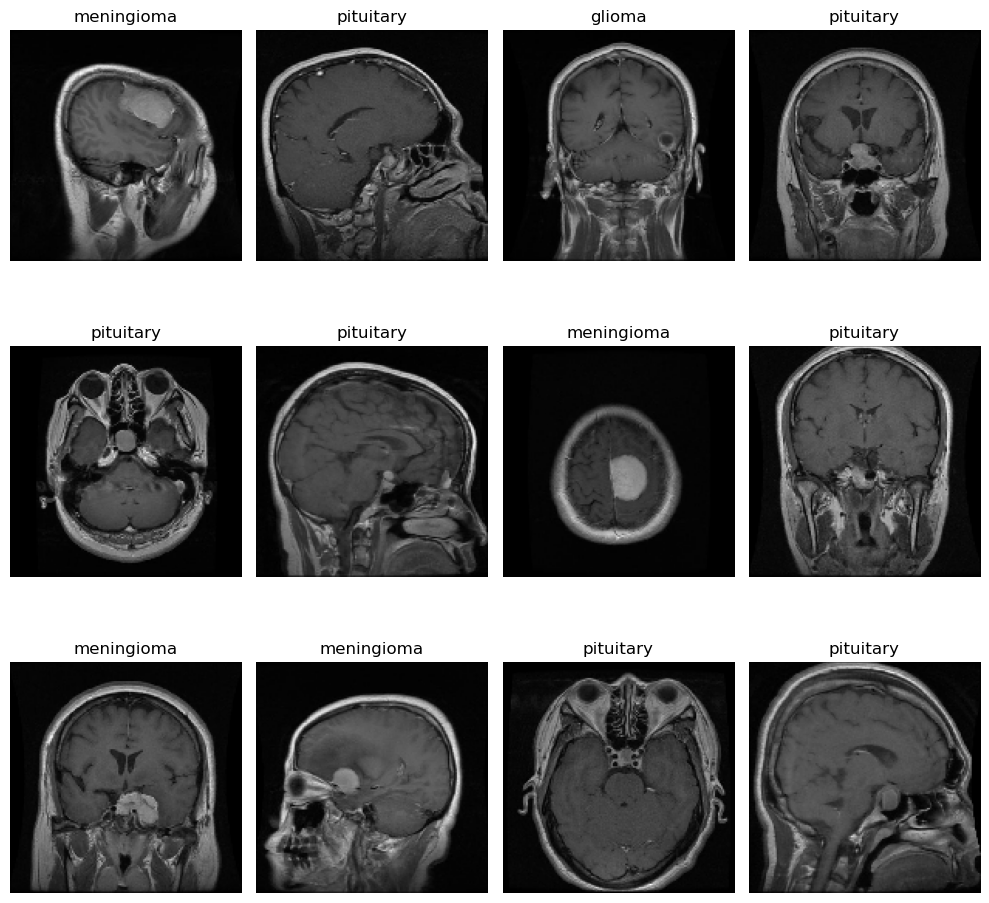

In [22]:
images, labels = next(train_data)
class_names = list(train_data.class_indices.keys())

def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    
    # Display 9 images from the batch
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_images(images, labels, class_names)

In [ ]:
# Model architecture